# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [2]:
# Q1 (code)
!pip install tomotopy
!pip install little-mallet-wrapper


  Obtaining dependency information for little-mallet-wrapper from https://files.pythonhosted.org/packages/e3/01/7e8561e33e79b408d9526b22b50e20bfdd8e551979237ad5c972759fe7d8/little_mallet_wrapper-0.5.0-py3-none-any.whl.metadata


In [3]:
import tomotopy as tp
import little_mallet_wrapper
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn
import glob
from pathlib import Path


## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [40]:
# Q2 (code)

# Load the datasets
sanders_tweets = pd.read_csv('sanders_tweets.csv')
trump_tweets = pd.read_csv('trump_tweets.csv')

# Concatenate the datasets
combined_tweets = pd.concat([sanders_tweets, trump_tweets], ignore_index=True)

# Display the first few rows of the combined dataset
print(combined_tweets)


               Username              TweetId  \
0            SenSanders  1351670845639421952   
1            SenSanders  1351259762722279424   
2            SenSanders  1351242822293319680   
3            SenSanders  1350885541911400448   
4            SenSanders  1349880150041780224   
...                 ...                  ...   
30366  @realDonaldTrump  1346912780700577792   
30367  @realDonaldTrump  1346928882595885058   
30368  @realDonaldTrump  1347334804052844550   
30369  @realDonaldTrump  1347555316863553542   
30370  @realDonaldTrump  1347569870578266115   

                                      Title  \
0            SenSanders_1351670845639421952   
1            SenSanders_1351259762722279424   
2            SenSanders_1351242822293319680   
3            SenSanders_1350885541911400448   
4            SenSanders_1349880150041780224   
...                                     ...   
30366  @realDonaldTrump_1346912780700577792   
30367  @realDonaldTrump_1346928882595885058   


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [84]:
# Q3 (code)

import re
import string
from nltk.corpus import stopwords
import pandas as pd
from pathlib import Path
import little_mallet_wrapper


# 定义一个函数来清洗文本
def preprocess_text(text):
    # 移除 URL
    text = re.sub(r"http\S+|www\S+|https\S+|\/\/t|co\/|\@\w+|realdonaldtrump", '', text, flags=re.MULTILINE)
    return text

# 初始化列表
training_data = []
original_texts = []
titles = []

# 遍历每个推文，清洗文本，并添加到列表中
for index, row in combined_tweets.iterrows():
    text = preprocess_text(row['Content'])
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)
    original_texts.append(row['Content'])
    titles.append(f"{row['Username']}-{row['TweetId']}")

# 打印清洗后的文本示例
print(training_data[:5])


['wealth increase past months billion elon musk billion jeff bezos billion walton family billion bill gates billion mark zuckerberg year increase minimum wage must tax rich raise minimum wage least', 'amidst massive income wealth inequality tens millions americans working starvation wages need raise minimum wage living wage least hour excuses need act', 'resources skills techniques get rid poverty question whether nation martin luther king', 'surviving attempt life russian activist alexei navalny detained bravely returning russia today call release united states must stand fighting corruption working democracy around world', 'president elect biden covid rescue plan begin provide people much needed support direct payments minimum wage look forward working colleagues congress urgently provide bold relief working families']


In [41]:
print(titles[:5])

['SenSanders-1351670845639421952', 'SenSanders-1351259762722279424', 'SenSanders-1351242822293319680', 'SenSanders-1350885541911400448', 'SenSanders-1349880150041780224']


## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [13]:
# Q4 (code)

# Number of topics
num_topics = 15

# Numer of topic words to print out
num_topic_words = 10

# Initialize the LDA model
lda_model = tp.LDAModel(k=num_topics)

# Add each document to the model
for doc in training_data:
    lda_model.add_doc(doc.split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    lda_model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {lda_model.ll_per_word}')


Topic Model Training...


Iteration: 0	Log-likelihood: -9.271584954167308
Iteration: 10	Log-likelihood: -8.872478716183801
Iteration: 20	Log-likelihood: -8.686877628557625
Iteration: 30	Log-likelihood: -8.591536119881312
Iteration: 40	Log-likelihood: -8.52592692783028
Iteration: 50	Log-likelihood: -8.482347317774396
Iteration: 60	Log-likelihood: -8.447220747027423
Iteration: 70	Log-likelihood: -8.421691657751206
Iteration: 80	Log-likelihood: -8.39885969392739
Iteration: 90	Log-likelihood: -8.382164706229336


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [14]:
# Q5a (code)
# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in lda_model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

people must country american right change stand together trump fight

✨Topic 1✨

trump war must court senate president end justice supreme bill

✨Topic 2✨

border military strong endorsement wall total great crime complete amendment

✨Topic 3✨

workers wage million wealth class living working americans middle minimum

✨Topic 4✨

health care people americans million drug right wall street must

✨Topic 5✨

law tonight god people america covid enforcement watch president coronavirus

✨Topic 6✨

china states united trade deal many great good countries president

✨Topic 7✨

biden joe election vote trump democrat would democrats left win

✨Topic 8✨

trump president years ever economy jobs history great best record

✨Topic 9✨

democrats impeachment nothing president house dems witch hunt want never

✨Topic 10✨

trump fbi campaign president russia obama hillary clinton collusion comey

✨Topic 11✨

tax workers security trump social american need must families 

In [ ]:
# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?
❗️

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [15]:
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(lda_model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(lda_model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.587178327118357 
Per Topic: [0.5265202410519123, 0.4617489457130432, 0.7645722329616547, 0.738423439860344, 0.6206072837114334, 0.4698771879076958, 0.5693016201257706, 0.5951092720031739, 0.5044587612152099, 0.6563736200332642, 0.7464018732309341, 0.5901895448565483, 0.5010364636778831, 0.49431807845830916, 0.5687363419681788]



### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

In [ ]:
# Q6 (words)
❗️

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

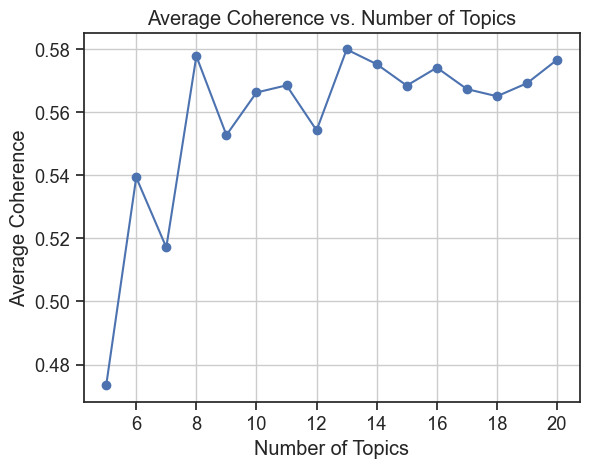

In [17]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model
import matplotlib.pyplot as plt
import tomotopy as tp

def plot_average_coherence(data, start=5, end=20, step=1):
    coherence_scores = []
    num_topics_range = range(start, end+1, step)
    
    for num_topics in num_topics_range:
        model = tp.LDAModel(k=num_topics)
        for text in data:
            model.add_doc(text.strip().split())
        model.train(100)  
        coh = tp.coherence.Coherence(model, coherence='c_v')
        coherence_scores.append(coh.get_score())

    plt.plot(num_topics_range, coherence_scores, marker='o')
    plt.title('Average Coherence vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Coherence')
    plt.grid(True)
    plt.show()

# Usage example
plot_average_coherence(training_data)


### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [18]:
topic_distributions = [list(doc.get_topic_dist()) for doc in lda_model.docs]

In [127]:
sorted_topic_distribution_with_index = sorted(enumerate(topic_distributions[30]), key=lambda x: x[1], reverse=True)
sorted_topic_distribution_with_index 

[(9, 0.47079682),
 (3, 0.43144202),
 (7, 0.040920798),
 (8, 0.006539559),
 (0, 0.006413176),
 (13, 0.0061802734),
 (6, 0.004768935),
 (4, 0.0045467135),
 (1, 0.004523316),
 (11, 0.0044354),
 (5, 0.00424877),
 (10, 0.00421978),
 (12, 0.0041717505),
 (14, 0.004012737),
 (2, 0.002779938)]

In [132]:
from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):

    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    topic_words = topics[topic_index]

    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")

    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')

    return

In [133]:
get_top_docs(titles, topic_distributions, topic_index=0, n=6)

### ✨Topic 0✨

people must country american right change stand together trump fight



---


✨  
**Topic Probability**: 0.9183106422424316  
**Document**: SenSanders-1049679265317445632



✨  
**Topic Probability**: 0.905394971370697  
**Document**: @realDonaldTrump-1230677422795706369



✨  
**Topic Probability**: 0.8942482471466064  
**Document**: SenSanders-1158488442021588992



✨  
**Topic Probability**: 0.8876281976699829  
**Document**: SenSanders-829154347137245184



✨  
**Topic Probability**: 0.8876281976699829  
**Document**: SenSanders-826496259070517248



✨  
**Topic Probability**: 0.8801239728927612  
**Document**: SenSanders-749378175638106112



In [134]:
obituary_to_check = "SenSanders_1351242822293319680"

obit_number = titles.index(obituary_to_check)

print(f"Topic Distributions for {titles[obit_number]}\n")
for topic_number, (topic, topic_distribution) in enumerate(zip(topics, topic_distributions[obit_number])):
    print(f"✨Topic {topic_number} {topic[:40]} ✨\nProbability: {round(topic_distribution, 3)}\n")

ValueError: 'SenSanders_1351242822293319680' is not in list

Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

In [ ]:
# Q7b (words)
❗️

## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [70]:
# Crete a sample of tweets

from random import sample

target_labels = sample(titles,100)

In [71]:
# Q8 (code)
# Create a heatmap using the random sample
# Tip: to display more than 20 tweets you have to change the values of `dim =` in sns.heatmap()
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', font_scale=1.2)
def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=25):

    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

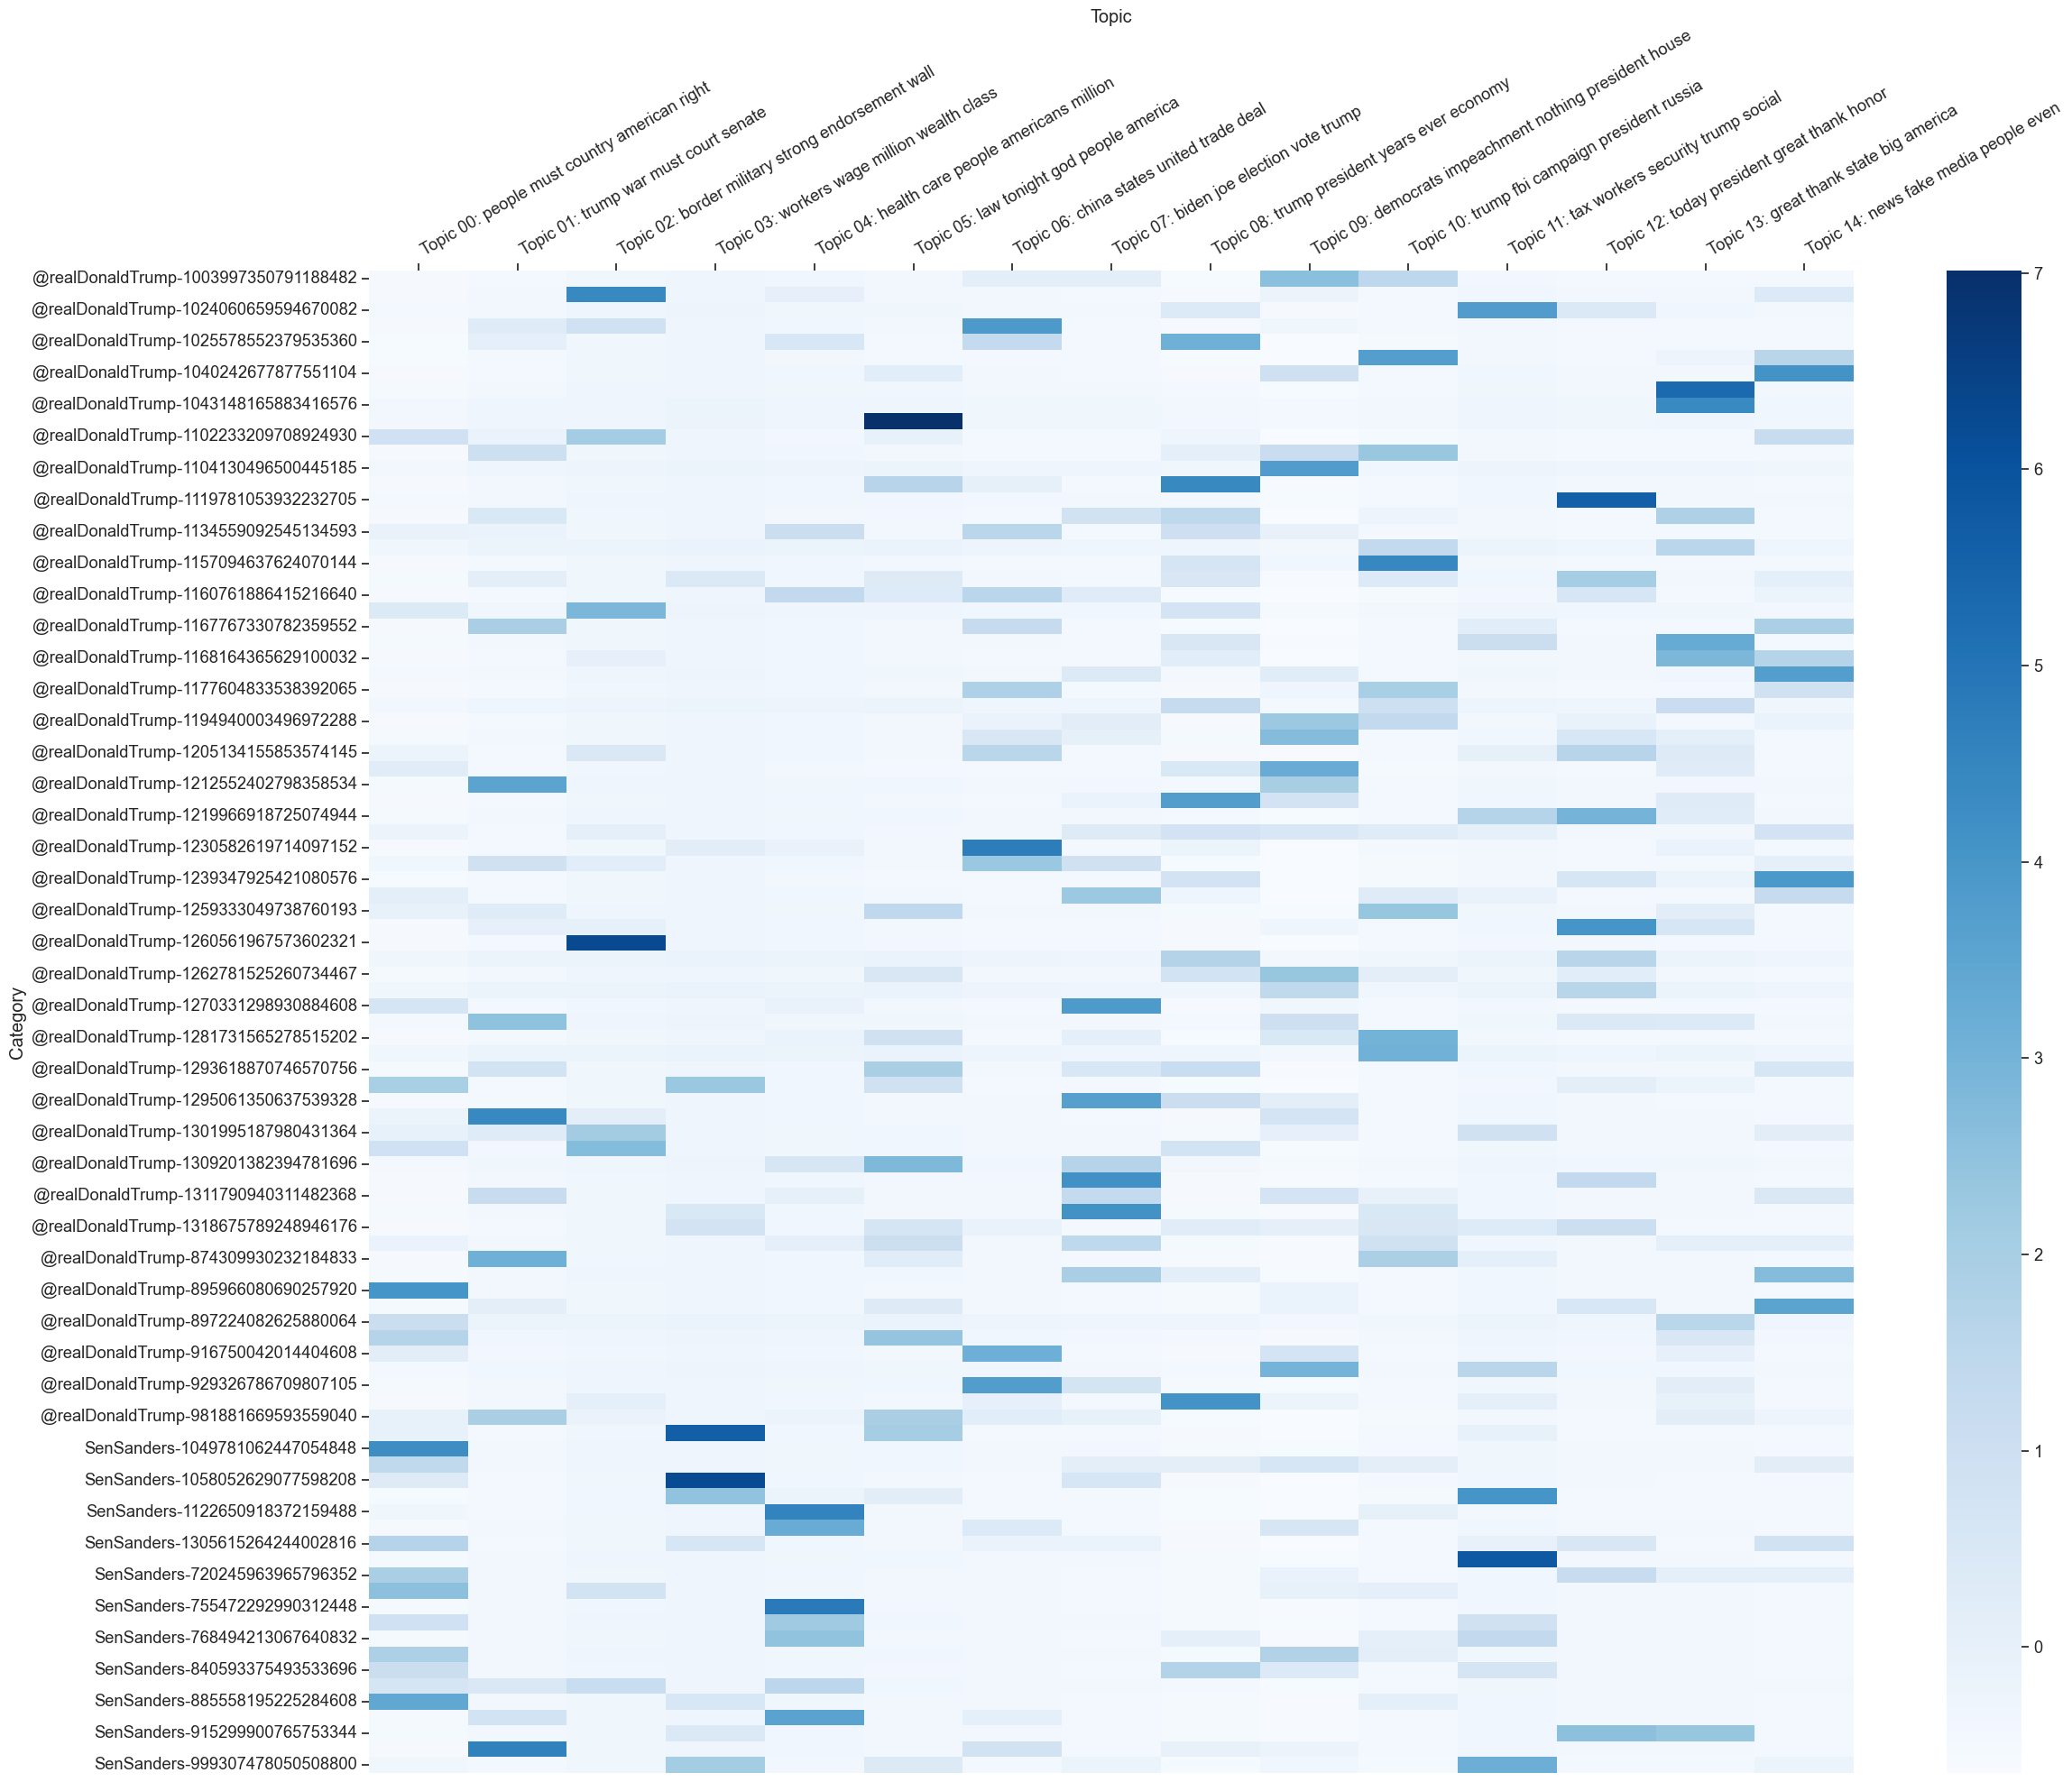

In [73]:
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Blues',
                                 dim=(25,20))


### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

In [ ]:
# Q9 (words)

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [ ]:
# X2 (code)


### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [ ]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)